*Проект e-commerce: вариант 1*

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз? (7 баллов) 

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)? (5 баллов)

3. По каждому товару определить, в какой день недели товар чаще всего покупается. (5 баллов)

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. (8 баллов) 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут. (10 баллов)

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут. (35 баллов)

Для решения задачи проведи предварительное исследование данных и сформулируй, что должно считаться покупкой. Обосновать свой выбор ты можешь с помощью фактов оплат, статусов заказов и других имеющихся данных.

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import calendar

In [2]:
# Откроем файл с данными по клиентам
customers = pd.read_csv('olist_customers_dataset.csv')
# olist_customers_datase.csv — таблица с уникальными идентификаторами пользователей 
# customer_id — позаказный идентификатор пользователя
# customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)
# customer_zip_code_prefix — почтовый индекс пользователя
# customer_city — город доставки пользователя
# customer_state — штат доставки пользователя

In [3]:
# Посмотрим на содержимое этого датафрейма
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [4]:
# Посмотрим на размер этого датафрейма - 99441 строк и 5 колонок
customers.shape

(99441, 5)

In [5]:
# Посмотрим на типы данных в этом датафрейме, всё логично и типы менять не нужно
customers.dtypes

customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object

In [6]:
# Посмотрим на количество уникальных значений в каждой колонке, 
# в customer_id количество совпадает с общим количеством строк, значит задвоений здесь нет
# всего уникальных пользователей 96096, а заказов они создали 99441, на 3345 больше
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

In [7]:
# Откроем файл с данными по заказам
orders = pd.read_csv('olist_orders_dataset.csv')
# olist_orders_dataset.csv —  таблица заказов
# order_id —  уникальный идентификатор заказа (номер чека)
# customer_id —  позаказный идентификатор пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки

In [8]:
# Посмотрим на содержимое этого датафрейма
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [9]:
# Посмотрим на размер этого датафрейма - 99441 строк и 8 колонок, количество строк совпадает с числом строк в датафрейме про клиентов
orders.shape

(99441, 8)

In [10]:
# Посмотрим на типы данных в этом датафрейме, здесь даты нужно привести к типу datetime
orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [11]:
# Переведем колонки с датами в формат datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders.order_purchase_timestamp)
orders['order_approved_at'] = pd.to_datetime(orders.order_approved_at)
orders['order_delivered_carrier_date'] = pd.to_datetime(orders.order_delivered_carrier_date)
orders['order_delivered_customer_date'] = pd.to_datetime(orders.order_delivered_customer_date)
orders['order_estimated_delivery_date'] = pd.to_datetime(orders.order_estimated_delivery_date)
orders.dtypes

order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [12]:
# Посмотрим на количество уникальных значений в каждой колонке, 
# в order_id и customer_id количество совпадает с общим количеством строк, значит задвоений здесь нет
# количество уникальных customer_id совпадает с количеством уникальных customer_id из датафрейма клиентов, значит они скорее всего совпадают
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

In [13]:
# Посмотрим на минимальные даты, имеющиеся в датафрейме - сентябрь 2016
orders.min()

order_id                         00010242fe8c5a6d1ba2dd792cb16214
customer_id                      00012a2ce6f8dcda20d059ce98491703
order_status                                             approved
order_purchase_timestamp                      2016-09-04 21:15:19
order_approved_at                             2016-09-15 12:16:38
order_delivered_carrier_date                  2016-10-08 10:34:01
order_delivered_customer_date                 2016-10-11 13:46:32
order_estimated_delivery_date                 2016-09-30 00:00:00
dtype: object

In [14]:
# Посмотрим на максимальные даты, имеющиеся в датафрейме - ноябрь 2018
orders.max()

order_id                         fffe41c64501cc87c801fd61db3f6244
customer_id                      ffffe8b65bbe3087b653a978c870db99
order_status                                          unavailable
order_purchase_timestamp                      2018-10-17 17:30:18
order_approved_at                             2018-09-03 17:40:06
order_delivered_carrier_date                  2018-09-11 19:48:28
order_delivered_customer_date                 2018-10-17 13:22:46
order_estimated_delivery_date                 2018-11-12 00:00:00
dtype: object

In [15]:
# Посмотрим на распределение заказов по статусам, самый массовый статус - delivered
orders.order_status.value_counts()
# Уникальные статусы заказов в таблице olist_orders_dataset:
# created —  создан
# approved —  подтверждён
# invoiced —  выставлен счёт
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# delivered —  доставлен пользователю
# unavailable —  недоступен
# canceled —  отменён

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

*1. Сколько у нас пользователей, которые совершили покупку только один раз?*

In [16]:
# Чтобы определить, что можно считать покупкой, посмотрим на: 
# 1) наличие значения в колонке order_approved_at —  время подтверждения оплаты заказа 
# 2) статус заказа: 
#     доставлен, отгружен со склада, выставлен счёт, в процессе сборки заказа, подтверждён 
#     - даже если клиент ещё не получил заказ, он уже его сделал и оплатил - значит покупка совершена.
orders\
    .query('order_approved_at.isna() == False and order_status in ("delivered", "shipped", "invoiced", "processing", "approved")')\
    .shape[0]

98188

Всего клиенты совершили 98188 покупок (количество товаров в одной покупке может быть больше 1)

In [17]:
# Сохраним фильтр для определения покупок в переменную purchases
purchases = 'order_approved_at.isna() == False and order_status in ("delivered", "shipped", "invoiced", "processing", "approved")'

In [18]:
# Объединим 2 датафрейма
orders_customers = orders.merge(customers, how = 'inner', on = 'customer_id')

In [19]:
# Посмотрим на получившийся датафрейм orders_customers
orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [20]:
# Посмотрим, сколько пользователей совершили покупку только один раз
orders_customers\
    .query(purchases)\
    .customer_unique_id\
    .value_counts()\
    .to_frame()\
    .reset_index()\
    .query('customer_unique_id == 1')\
    .shape[0]

92087

*Ответ: 92087 пользователей совершили покупку только один раз*

*2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?*

In [21]:
# Недоставленными будем считать заказы, которые должны были быть доставлены, но у которых:
# 1) нет значения в колонке время доставки заказа - order_delivered_customer_date
# 2) статус заказа : # processing —  в процессе сборки заказа
#     shipped —  отгружен со склада
#     unavailable —  недоступен
#     canceled —  отменён
orders_customers\
    .query('order_delivered_customer_date.isna() and order_status in ("shipped", "unavailable", "processing", "canceled")')\
    .shape[0]

2636

Всего не доставлено 2636 заказов

In [22]:
# Сохраним фильтр для недоставленных заказов в переменную undelivered
undelivered = 'order_delivered_customer_date.isna() and order_status in ("shipped", "unavailable", "processing", "canceled")'

In [23]:
# Посчитаем, сколько заказов в среднем не доставляется в месяц
orders_customers\
    .query(undelivered)\
    .resample('M', on='order_estimated_delivery_date')\
    .count()\
    .order_id\
    .mean()\
    .round()

98.0

*Ответ: В среднем не доставляется 98 заказов в месяц*

In [24]:
# Посмотрим на статусы недоставленных заказов, чтобы определить причину
orders_customers.query(undelivered)\
    .order_status\
    .value_counts()
# processing —  в процессе сборки заказа
# shipped —  отгружен со склада
# unavailable —  недоступен
# canceled —  отменён

shipped        1107
canceled        619
unavailable     609
processing      301
Name: order_status, dtype: int64

*Ответ:*

Больше всего - 1107 заказов - было отгружено со склада, но недоставлено - значит нужно поработать со службой доставки (возможно они были доставлены, но информация не пришла; или служба доставки "потеряла" эти заказы и нужно о них напомнить);

619 заказов было отменено (из данных не ясно - пользователями или системой, соответственно не ясно, куда копать дальше);

609 заказов имеет статус "недоступно", что видимо значит отсутствие товаров (стоит поработать с поставщиками, чтобы такого случалось как можно меньше);

301 заказ остановился на процессе сборки заказов (если бы мы смотрели на данные в реальном времени, возможно это было бы нормальным показателем, но так как мы анализируем прошлое время, то видимо эти заказы так и не были собраны - нужно с соответствующей службой разбираться, почему);

*3. По каждому товару определить, в какой день недели товар чаще всего покупается.*

In [25]:
# Откроем файл с данными по товарам
items = pd.read_csv('olist_order_items_dataset.csv')
# olist_order_items_dataset.csv —  товарные позиции, входящие в заказы
# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

In [26]:
# Посмотрим на содержимое этого датафрейма
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [27]:
# Посмотрим на размер этого датафрейма - 112650 строк и 7 колонок
# В этом датафрейме количество строк больше, чем в предыдущем, что связано с тем, что в одном заказе может быть несколько товаров
#     и для каждого из товаров здесь отдельная строка
items.shape

(112650, 7)

In [28]:
# Посмотрим на типы данных в этом датафрейма, здесь даты нужно привести к типу datetime
items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [29]:
# Переведем колонку с датами в формат datetime
items['shipping_limit_date'] = pd.to_datetime(items.shipping_limit_date)
items.dtypes

order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object

In [30]:
# Посмотрим на количество уникальных значений в каждой колонке, 
# Количество уникальных order_id меньше, чем в датафрейме с заказами (не записались данные? или некоторые заказы были без товаров?)
# Всего в заказы за все время было добавлено 32951 уникальных товаров от 3095 продавцов
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

In [31]:
# Добавим к датафрейму о товарах данные из других датафреймов
data = items.merge(orders_customers, how = 'left', on = 'order_id')
# customer_id — позаказный идентификатор пользователя
# customer_unique_id — уникальный идентификатор пользователя (аналог номера паспорта)
# customer_zip_code_prefix — почтовый индекс пользователя
# customer_city — город доставки пользователя
# customer_state — штат доставки пользователя
# order_status —  статус заказа
# order_purchase_timestamp —  время создания заказа
# order_approved_at —  время подтверждения оплаты заказа
# order_delivered_carrier_date —  время передачи заказа в логистическую службу
# order_delivered_customer_date —  время доставки заказа
# order_estimated_delivery_date —  обещанная дата доставки
# order_id —  уникальный идентификатор заказа (номер чека)
# order_item_id —  идентификатор товара внутри одного заказа
# product_id —  ид товара (аналог штрихкода)
# seller_id — ид производителя товара
# shipping_limit_date —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике
# price —  цена за единицу товара
# freight_value —  вес товара

In [32]:
# Посмотрим на содержимое полного датафрейма
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


In [33]:
# Посмотрим на размер полного датафрейма
data.shape

(112650, 18)

In [34]:
# Посмотрим на количество пропущенных значений в колонках
data.isna().sum()

order_id                            0
order_item_id                       0
product_id                          0
seller_id                           0
shipping_limit_date                 0
price                               0
freight_value                       0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                  15
order_delivered_carrier_date     1194
order_delivered_customer_date    2454
order_estimated_delivery_date       0
customer_unique_id                  0
customer_zip_code_prefix            0
customer_city                       0
customer_state                      0
dtype: int64

In [35]:
# Создадим колонку, в которой будут написаны дни недели, в которые совершена покупка
data['order_approved_at_weekday'] = data.order_approved_at.dt.strftime('%A')

In [36]:
# Отсортируем только записи с покупками, и посмотрим, в какой день недели каждый товар сколько покупается.
# Отсортируем список по убыванию и удалим повторяющие записи с id товаров
# Сохраним данные в sales_by_weekdays
sales_by_weekdays = data\
    .query(purchases)\
    .groupby(['product_id','order_approved_at_weekday'], as_index = False)\
    .agg({'order_approved_at':'count'})\
    .sort_values(['order_approved_at', 'product_id'], ascending = False)\
    .drop_duplicates(subset = 'product_id')\
    .reset_index(drop=True)\
    .rename(columns = {'order_approved_at_weekday' : 'weekday', 'order_approved_at' : 'quantity_of_sales'})
sales_by_weekdays

,product_id,weekday,quantity_of_sales
0,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,119
1,53b36df67ebb7c41585e8d54d6772e08,Tuesday,105
2,422879e10f46682990de24d770e7f83d,Tuesday,89
3,99a4788cb24856965c36a24e339b6058,Tuesday,82
4,368c6c730842d78016ad823897a372db,Thursday,80
...,...,...,...
32721,000d9be29b5207b54e86aa1b1ac54872,Tuesday,1
32722,000b8f95fcb9e0096488278317764d19,Friday,1
32723,0009406fd7479715e4bef61dd91f2462,Friday,1
32724,00088930e925c41fd95ebfe695fd2655,Tuesday,1


*По каждому товару мы определили, в какой день недели товар чаще всего покупается. Мы оставили только по 1 дню для каждого товара, потому что в задании было указано "день", а не "дни"*

*4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть*

In [37]:
# Создадим в датафрейме с заказами и пользователями новую колонку, в которой будут год и месяц совершения покупки
orders_customers['order_approved_at_months'] = orders_customers\
    .query(purchases)\
    .order_approved_at\
    .apply(lambda x : x.strftime('%Y-%m'))

In [38]:
# Создадим новый датафрейм purchases_customers_by_months, в который положим количество покупок по месяцам на каждого пользователя
purchases_customers_by_months = orders_customers.query(purchases)\
    .groupby(['customer_unique_id', 'order_approved_at_months'], as_index = False)\
    .agg({'order_approved_at' : 'count'})\
    .sort_values('customer_unique_id')\
    .rename(columns = {'order_approved_at' : 'purchases_by_month'})

In [39]:
# Создадим новую колонку с количеством недель в месяце
purchases_customers_by_months['weeks_at_month'] = purchases_customers_by_months.order_approved_at_months.apply(lambda x : pd.Period(x).days_in_month) / 7

In [40]:
# Посчитаем среднее количество покупок в неделю по месяцам на каждого пользователя
purchases_customers_by_months['purchases_mean_by_week'] = round(purchases_customers_by_months.purchases_by_month / purchases_customers_by_months.weeks_at_month, 2)

In [41]:
# Уберем ненужные теперь колонки
purchases_customers_by_months = purchases_customers_by_months.drop(['purchases_by_month', 'weeks_at_month'], axis=1)

In [42]:
# Переведем колонку с месяцами в столбцы и заполним пустые значения 0, 
#     потому что в пропущенные месяцы пользователи не делали покупок - значит среднее количество равно 0
# Сохраним данные в purchases_customers_by_months
purchases_customers_by_months = purchases_customers_by_months.rename(columns = {'order_approved_at_months' : 'months'})\
    .pivot(columns = 'months', index = 'customer_unique_id')\
    .fillna(0)

In [43]:
# Посмотрим на получившийся датафрейм
purchases_customers_by_months.head()

purchases_mean_by_week                  \
months                                          2016-09 2016-10 2016-12   
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                    0.0     0.0     0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    0.0     0.0     0.0   
0000f46a3911fa3c0805444483337064                    0.0     0.0     0.0   
0000f6ccb0745a6a4b88665a16c9f078                    0.0     0.0     0.0   
0004aac84e0df4da2b147fca70cf8255                    0.0     0.0     0.0   

                                                                          \
months                           2017-01 2017-02 2017-03 2017-04 2017-05   
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2     0.0     0.0    0.00     0.0     0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f     0.0     0.0    0.00     0.0     0.0   
0000f46a3911fa3c0805444483337064     0.0     0.0    0.23     0.0     0.0   
0000f6ccb0745a6a4b88665a16c9f078     0.0     0.0    0.00     0.0     0.0   
0004aac84e0df4da2b147fca70cf8255     0.0     0.0    0.00     0.0     0.0   

                                                  ...                          \
months                           2017-06 2017-07  ... 2017-12 2018-01 2018-02   
customer_unique_id                                ...                           
0000366f3b9a7992bf8c76cfdf3221e2     0.0     0.0  ...     0.0     0.0     0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f     0.0     0.0  ...     0.0     0.0     0.0   
0000f46a3911fa3c0805444483337064     0.0     0.0  ...     0.0     0.0     0.0   
0000f6ccb0745a6a4b88665a16c9f078     0.0     0.0  ...     0.0     0.0     0.0   
0004aac84e0df4da2b147fca70cf8255     0.0     0.0  ...     0.0     0.0     0.0   

                                                                          \
months                           2018-03 2018-04 2018-05 2018-06 2018-07   
customer_unique_id                                                         
0000366f3b9a7992bf8c76cfdf3221e2     0.0     0.0    0.23     0.0     0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f     0.0     0.0    0.23     0.0     0.0   
0000f46a3911fa3c0805444483337064     0.0     0.0    0.00     0.0     0.0   
0000f6ccb0745a6a4b88665a16c9f078     0.0     0.0    0.00     0.0     0.0   
0004aac84e0df4da2b147fca70cf8255     0.0     0.0    0.00     0.0     0.0   

                                                  
months                           2018-08 2018-09  
customer_unique_id                                
0000366f3b9a7992bf8c76cfdf3221e2     0.0     0.0  
0000b849f77a49e4a4ce2b2a4ca5be3f     0.0     0.0  
0000f46a3911fa3c0805444483337064     0.0     0.0  
0000f6ccb0745a6a4b88665a16c9f078     0.0     0.0  
0004aac84e0df4da2b147fca70cf8255     0.0     0.0  

[5 rows x 24 columns]

*Итак, мы посчитали сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)*

*5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц*

In [44]:
# Отфильтруем датафрейм с клиентами и заказами, оставив только записи о покупках за 2017й год + 3 месяца 2018го,
#     так как нам нужно провести когортный анализ за период с января по декабрь + 3 месяца
orders_customers_purchases = orders_customers.query((purchases) and ('"2016-12" < order_approved_at_months < "2018-04"'))

In [45]:
# Определим, в каком месяце каждый пользователь совершил свою первую покупку
first_purchase = orders_customers_purchases\
    .groupby('customer_unique_id', as_index = False)\
    .agg({'order_approved_at_months': 'min'})\
    .rename(columns = ({'order_approved_at_months' : 'first_purchase_at_months'}))

In [46]:
# Добавим данные о месяце первой покупки к датафрейму с данными о клиентах и заказах
orders_customers_first_purchases = orders_customers_purchases.merge(first_purchase, how = 'inner', on = 'customer_unique_id')

In [47]:
# Переведем колонки с датами в формат datetime
orders_customers_first_purchases['order_approved_at_months'] = pd.to_datetime(orders_customers_first_purchases.order_approved_at_months)
orders_customers_first_purchases['first_purchase_at_months'] = pd.to_datetime(orders_customers_first_purchases.first_purchase_at_months)

In [48]:
# Создадим новую колонку со разницей между датой покупки и датой первой покупки
orders_customers_first_purchases['diff'] = orders_customers_first_purchases.order_approved_at_months - orders_customers_first_purchases.first_purchase_at_months

In [49]:
# Оставим только записи о покупках, совершенных на 3й месяц после первой
orders_customers_third_purchases = orders_customers_first_purchases.loc[orders_customers_first_purchases['diff'] <= '92 days'].loc[orders_customers_first_purchases['diff'] >= '89 days']

In [50]:
# Сформируем когорты с количеством покупок в 3й месяц
cohorts = orders_customers_third_purchases\
    .groupby(['first_purchase_at_months','diff'], as_index = False)\
    .agg({'order_approved_at_months':'count'})\
    .rename(columns = ({'order_approved_at_months' : 'third_month_customer'}))
cohorts

,first_purchase_at_months,diff,third_month_customer
0,2017-01-01,90 days,1
1,2017-02-01,89 days,3
2,2017-03-01,92 days,11
3,2017-04-01,91 days,5
4,2017-05-01,92 days,14
5,2017-06-01,92 days,12
6,2017-07-01,92 days,7
7,2017-08-01,92 days,11
8,2017-09-01,91 days,18
9,2017-10-01,92 days,4


In [51]:
# Сформируем когорты с количеством первых покупок
first_month_customers = orders_customers_first_purchases\
    .query(purchases)\
    .groupby('first_purchase_at_months', as_index = False)\
    .agg({'customer_id' : 'count'})\
    .rename(columns = ({'customer_id' : 'first_month_customer'}))

In [52]:
# Оставим только записи о первых покупках в 2017 году
first_month_customers_2017 = first_month_customers.query('"2016-12" < first_purchase_at_months < "2018-01"').reset_index(drop = True)

In [53]:
# Соединим датафреймы с когортами в один
first_third_month_customers = first_month_customers_2017.merge(cohorts, how = 'inner', on = 'first_purchase_at_months')

In [54]:
# Посчитаем колонку retention в %
first_third_month_customers['retention_percent'] = round(100 * first_third_month_customers.third_month_customer / first_third_month_customers.first_month_customer, 2)

In [55]:
# Отсортируем записи по размеру retention
first_third_month_customers.sort_values('retention_percent')

,first_purchase_at_months,first_month_customer,diff,third_month_customer,retention_percent
9,2017-10-01,4488,92 days,4,0.09
0,2017-01-01,779,90 days,1,0.13
10,2017-11-01,7249,92 days,11,0.15
1,2017-02-01,1742,89 days,3,0.17
6,2017-07-01,3935,92 days,7,0.18
3,2017-04-01,2405,91 days,5,0.21
7,2017-08-01,4351,92 days,11,0.25
4,2017-05-01,3742,92 days,14,0.37
5,2017-06-01,3255,92 days,12,0.37
11,2017-12-01,5706,90 days,21,0.37


*Ответ: когорта с самым высоким retention на 3й месяц - пользователи, сделавшие первую покупку в сентябре 2017 года, их retention составляет 0.42% (меньше половины процента)*

*6. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю*

In [56]:
# выберем только покупки из датафрейма data (в нем записи о клиентах, заказах и товарах), 
#     сгруппируем данные по клиентам, заказам и дате покупки, посчитаем общую сумму заказа. Положим эти данные в data_grouped
data_grouped = data.query(purchases)\
    .groupby(['customer_unique_id', 'order_id', 'order_approved_at'], as_index = False)\
    .agg({'price' : 'sum'})

In [57]:
# В столбце order_approved_at оставим только значение даты, без времени
data_grouped['order_approved_at'] = data_grouped.order_approved_at.dt.strftime('%Y-%m-%d')

In [58]:
# И переведем этот столбец обратно в формат datetime
data_grouped['order_approved_at'] = pd.to_datetime(data_grouped.order_approved_at)

In [59]:
# Создадим столбец now, в который положим дату на 1 день больше максимальной даты из датафрейма
#     (представим, что мы анализируем датафрейм в реальном времени, а не несколько лет спустя)
data_grouped['now'] = data_grouped.order_approved_at.max() + dt.timedelta(days=1)

In [60]:
# Создадим столбец difference, который показывает разницу между "сегодняшним" днем и датой покупки
data_grouped['difference'] = data_grouped.now - data_grouped.order_approved_at

In [61]:
# Посмотрим на получившийся датафрейм
data_grouped.head()

,customer_unique_id,order_id,order_approved_at,price,now,difference
0,0000366f3b9a7992bf8c76cfdf3221e2,e22acc9c116caa3f2b7121bbb380d08e,2018-05-10,129.90,2018-09-04,117 days
1,0000b849f77a49e4a4ce2b2a4ca5be3f,3594e05a005ac4d06a72673270ef9ec9,2018-05-07,18.90,2018-09-04,120 days
2,0000f46a3911fa3c0805444483337064,b33ec3b699337181488304f362a6b734,2017-03-10,69.00,2018-09-04,543 days
3,0000f6ccb0745a6a4b88665a16c9f078,41272756ecddd9a9ed0180413cc22fb6,2017-10-12,25.99,2018-09-04,327 days
4,0004aac84e0df4da2b147fca70cf8255,d957021f1127559cd947b62533f484f7,2017-11-14,180.00,2018-09-04,294 days


In [62]:
# Аггрегируем датафрейм, посчитав новые значения:
#     Recency - разница между "сегодняшним" днем и датой последней покупки пользователя
#     Frequency - сколько раз пользователь совершал покупку
#     Monetary - общая сумма покупок пользователя
# Положим эти данные в новый датафрейм data_rfm
data_rfm = data_grouped.groupby('customer_unique_id', as_index = False)\
    .agg({'difference' : 'min', 'order_id' : 'count', 'price' : 'sum'})\
    .rename(columns = ({'difference' : 'Recency_difference_after_last_purchase', 'order_id' : 'Frequency_orders_quantity', 'price' : 'Monetary_total_amount'}))

In [63]:
# Посмотрим на получившийся датафрейм
data_rfm.head()

,customer_unique_id,Recency_difference_after_last_purchase,Frequency_orders_quantity,Monetary_total_amount
0,0000366f3b9a7992bf8c76cfdf3221e2,117 days,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120 days,1,18.90
2,0000f46a3911fa3c0805444483337064,543 days,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,327 days,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,294 days,1,180.00


In [64]:
# Для создания сегментов разделим значение Recency на 5 квантилей
quintiles_R = data_rfm['Recency_difference_after_last_purchase'].quantile([.2, .4, .6, .8])
quintiles_R
# Значения Recency делятся на:
#     "менее 3 месяцев" (немного округлим дни до месяцев, в данном случае это оправданно)
#     "от 3 до 6 месяцев"
#     "от 6 до 9 месяцев"
#     "от 9 месяцев до года"
#     "более года"

0.2    98 days
0.4   182 days
0.6   273 days
0.8   389 days
Name: Recency_difference_after_last_purchase, dtype: timedelta64[ns]

In [65]:
# Создадим функцию r_score, которая будет присваивать рейтинг от 5 до 1 в зависимости от попадания значения в quintiles_R
def r_score(x):
    if x <= quintiles_R[.2]:
        return 5
    elif x <= quintiles_R[.4]:
        return 4
    elif x <= quintiles_R[.6]:
        return 3
    elif x <= quintiles_R[.8]:
        return 2
    else:
        return 1

In [66]:
# Разделим значение Frequency на 5 квантилей
quintiles_F = data_rfm['Frequency_orders_quantity'].quantile([.2, .4, .6, .8])
quintiles_F
# Мы видим, что все квантили приняли одно значение - "1", поэтому такой метод деления на сегменты нам здесь не подходит

0.2    1.0
0.4    1.0
0.6    1.0
0.8    1.0
Name: Frequency_orders_quantity, dtype: float64

In [67]:
# Посмотрим на распределение значений Frequency
data_rfm.Frequency_orders_quantity.value_counts()
# Абсолютное большинство клиентов (на несколько порядков больше) совершили покупку только 1 раз, 
#     далее идет значение 2 раза, и остальные, поэтому разделим эти значения на 3 сегмента

1     92084
2      2650
3       188
4        29
5         9
6         5
7         3
16        1
9         1
Name: Frequency_orders_quantity, dtype: int64

In [68]:
# Создадим функцию f_score, которая будет присваивать рейтинг от 1 до 3 в зависимости от количества покупок (1, 2, 3 и более)
def f_score(x):
    if x == 1:
        return 1
    elif x == 2:
        return 2
    else:
        return 3

In [69]:
# Разделим значение Monetary на 5 квантилей
quintiles_M = data_rfm['Monetary_total_amount'].quantile([.2, .4, .6, .8])
quintiles_M
# Значения Monetary делятся на:
#     "до 40 у.е."
#     "от 40 до 70 у.е."
#     "от 70 до 110 у.е."
#     "от 110 до 180 у.е."
#     "более 180 у.е."

0.2     39.9
0.4     69.9
0.6    109.9
0.8    179.9
Name: Monetary_total_amount, dtype: float64

In [70]:
# Создадим функцию m_score, которая будет присваивать рейтинг от 1 до 5 в зависимости от попадания значения в quintiles_M
def m_score(x):
    if x <= quintiles_M[.2]:
        return 1
    elif x <= quintiles_M[.4]:
        return 2
    elif x <= quintiles_M[.6]:
        return 3
    elif x <= quintiles_M[.8]:
        return 4
    else:
        return 5

In [71]:
# Создадим новые колонки R, F, M, отражающие значения каждого из 3 параметров (Recency, Frequency, Monetary), применив функции
data_rfm['R'] = data_rfm['Recency_difference_after_last_purchase'].apply(lambda x: r_score(x))
data_rfm['F'] = data_rfm['Frequency_orders_quantity'].apply(lambda x: f_score(x))
data_rfm['M'] = data_rfm['Monetary_total_amount'].apply(lambda x: m_score(x))

In [72]:
# Создадим новую колонку RFM_Score, в которой прописан RFM-код каждого покупателя
data_rfm['RFM_Score'] = data_rfm['R'].map(str) + data_rfm['F'].map(str) + data_rfm['M'].map(str)

In [73]:
# Посмотрим на получившийся датафрейм
data_rfm.head()

,customer_unique_id,Recency_difference_after_last_purchase,Frequency_orders_quantity,Monetary_total_amount,R,F,M,RFM_Score
0,0000366f3b9a7992bf8c76cfdf3221e2,117 days,1,129.90,4,1,4,414
1,0000b849f77a49e4a4ce2b2a4ca5be3f,120 days,1,18.90,4,1,1,411
2,0000f46a3911fa3c0805444483337064,543 days,1,69.00,1,1,2,112
3,0000f6ccb0745a6a4b88665a16c9f078,327 days,1,25.99,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,294 days,1,180.00,2,1,5,215


Сформируем 13 сегментов, на которые разделим пользователей по их RFM-кодам:

Название по-русски	- Описание	- Название в python

1й приоритет по назначению ячеек:		
1) Чемпионы	- Покупали недавно (не позже, чем 3 месяца назад), покупали часто (3 и более раз) и потратили больше всего (180 и более у.е.)	- Champions

2) Потенциальные чемпионы	- Покупали не слишком давно (не позже, чем полгода назад), покупали относительно часто (2 и более раз) и потратили достаточно много (более 110 у.е.)	- Potential_Champions

3) Перспективные новички	- Покупали не слишком давно (не позже, чем полгода назад), сделали 1 покупку, потратили средне (от 70 до 180 у.е.)	- Promising_Newcomers

4) Потерянные важные	- Давно не покупали (более 9 месяцев назад), сделали 2 и более покупок, тратили достаточно много (более 110 у.е.)	- Lost_important

5) Потерянные неважные	- Давно не покупали (более 9 месяцев назад), сделали покупку 1 раз и потратили немного (менее 70 у.е.)	- Lost_unimportant

2й приоритет по назначению ячеек:	

6) Уверенные середнячки	- Последний раз покупали от 6 до 9 месяцев назад, сделали покупки 1 или 2 раза, потратили средне (от 40 до 110 у.е.)	- Confident_middle_peasants

7) Просто новички	- Покупали не слишком давно (не позже, чем полгода назад), сделали 1 покупку, потратили мало (менее 70 у.е.)	- Just_Newcomers

8) Новички-чемпионы	- Покупали недавно (не позже, чем 3 месяца назад), купили 1 раз и потратили больше всего (180 и более у.е.)	- Champions_Newcomers

9) Потерянные средней важности	- Давно не покупали (более 6 месяцев назад), сделали покупку 1 или 2 раза, потратили немного (до 180 у.е.)	- Lost_medium_importance

10) Могут потеряться лояльные	- Покупали от 6 до 9 месяцев назад, покупали 3 и более раз, покупали на любую сумму	- Loyal_may_be_lost

Не попавшие в остальные группы (3й приоритет):	

11) Много платящие	- Купили на сумму более 180 у.е., 	- Paying_lot

12) Часто покупавшие	- Покупали 3 и более раз	- Frequent_Buyers

13) Недавно купившие	- Покупали не позже, чем полгода назад	- Recently_bought

Визуализация разбивки по сегментам здесь: https://docs.google.com/spreadsheets/d/1BAzO0Z6AKCPlALxBfFjja-tlyKZehH6fjX-oH6umiAk/edit?usp=sharing

In [74]:
# Присвоим названиям сегментов коды 
Champions = '535'
Potential_Champions = ['534', '525', '524', '435', '434', '425', '424']
Promising_Newcomers = ['514', '513', '512', '414', '413', '412']
Lost_important = ['235', '234', '225', '224', '135', '134', '125', '124']
Lost_unimportant = ['212', '211', '112', '111']
Confident_middle_peasants = ['324', '323', '322', '314', '313', '312']
Just_Newcomers = ['511', '411']
Champions_Newcomers = ['515']
Lost_medium_importance = ['321', '311', '223', '222', '221', '214', '213', '123', '122', '121', '114', '113']
Loyal_may_be_lost = ['335', '334', '332', '331']
Paying_lot = ['115', '215', '315', '325', '415']
Frequent_Buyers = ['131', '132', '133', '231', '232', '233', '333', '431', '432', '433', '531', '532', '533']
Recently_bought = ['421', '422', '423', '521', '522', '523']

In [75]:
# Создадим новую колонку Segment с названием сегмента клиента
data_rfm['Segment'] = data_rfm['RFM_Score'].replace(Champions, 'Champions')\
    .replace(Potential_Champions, 'Potential_Champions')\
    .replace(Promising_Newcomers, 'Promising_Newcomers')\
    .replace(Lost_important, 'Lost_important')\
    .replace(Lost_unimportant, 'Lost_unimportant')\
    .replace(Confident_middle_peasants, 'Confident_middle_peasants')\
    .replace(Just_Newcomers, 'Just_Newcomers')\
    .replace(Champions_Newcomers, 'Champions_Newcomers')\
    .replace(Lost_medium_importance, 'Lost_medium_importance')\
    .replace(Loyal_may_be_lost, 'Loyal_may_be_lost')\
    .replace(Paying_lot, 'Paying_lot')\
    .replace(Frequent_Buyers, 'Frequent_Buyers')\
    .replace(Recently_bought, 'Recently_bought')\

In [76]:
# Посмотрим, сколько клиентов представлено в каждом сегменте
data_rfm.Segment.value_counts()

Promising_Newcomers          22130
Lost_medium_importance       18037
Lost_unimportant             16004
Paying_lot                   14316
Confident_middle_peasants    11344
Just_Newcomers                7685
Champions_Newcomers           3425
Potential_Champions            898
Lost_important                 747
Recently_bought                272
Champions                       55
Loyal_may_be_lost               34
Frequent_Buyers                 23
Name: Segment, dtype: int64

In [77]:
# Соберем эти данные в датафрейм data_segments для визуализации
data_segments = data_rfm.Segment.value_counts()\
    .to_frame()\
    .reset_index()\
    .rename(columns = ({'Segment' : 'quantity_customers', 'index' : 'segment'}))

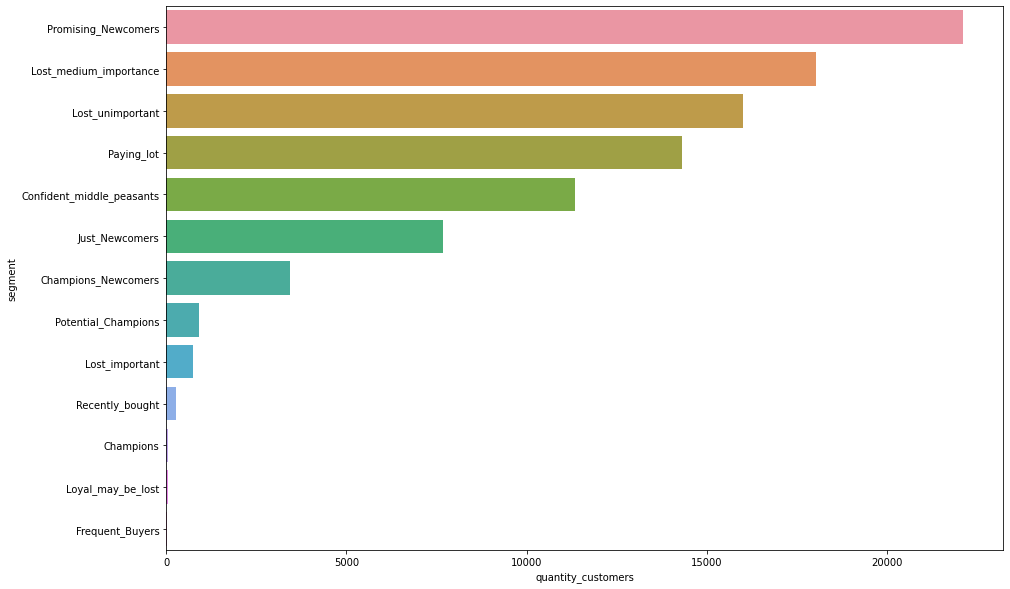

In [78]:
# Визуализируем распределение пользователей по сегментам
plt.figure(figsize = (15, 10))
sns.barplot(data = data_segments, y = 'segment', x = 'quantity_customers')

In [79]:
# Создадим датафрейм с данными о процентном соотношении сегментов
data_segments_percent = data_rfm.Segment.value_counts(normalize = True)\
    .to_frame()\
    .reset_index()\
    .rename(columns = ({'Segment' : 'segment_percentage', 'index' : 'segment'}))

In [80]:
# Приведем колонку с процентами к более наглядному виду
data_segments_percent['segment_percentage'] = round(100 * data_segments_percent.segment_percentage, 2)

In [81]:
# Посмотрим на распределение сегментов по %
data_segments_percent

,segment,segment_percentage
0,Promising_Newcomers,23.30
1,Lost_medium_importance,18.99
2,Lost_unimportant,16.85
3,Paying_lot,15.07
4,Confident_middle_peasants,11.94
5,Just_Newcomers,8.09
6,Champions_Newcomers,3.61
7,Potential_Champions,0.95
8,Lost_important,0.79
9,Recently_bought,0.29


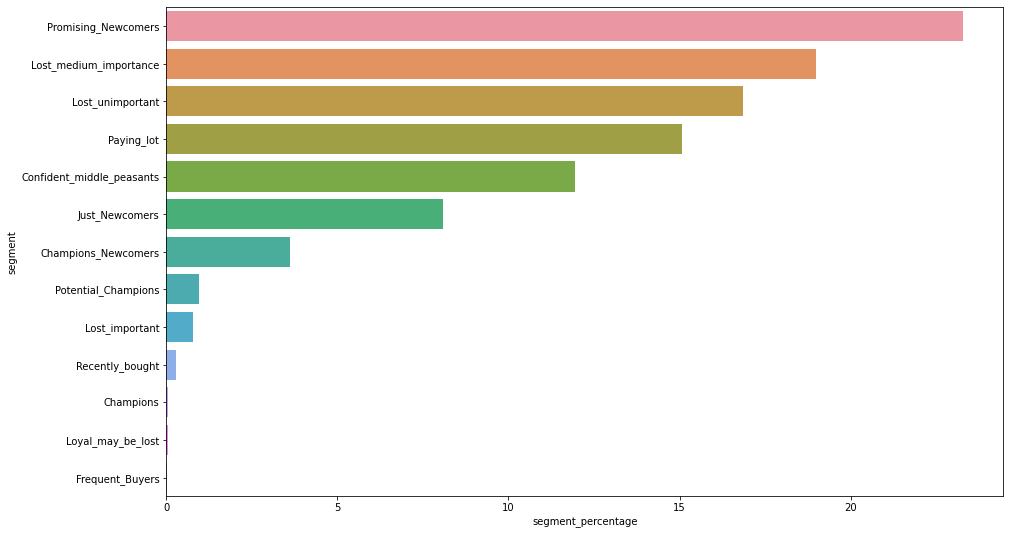

In [82]:
# Визуализируем распределение сегментов по процентам
plt.figure(figsize = (15, 9))
sns.barplot(data = data_segments_percent, y = 'segment', x = 'segment_percentage')

*Выводы* (у нас нет бенчмарка по отрасли или исторических данных нашей компании, поэтому в рекомендациях ориентируемся на примерные значения): 

1) Среди клиентов лидирует сегмент "Перспективные новички" (23.3%), кроме того "Просто новички" составляют 8.09%, а "Новички-чемпионы" - 3.61%. Общая доля новичков 35% - значит у компании есть потенциал к росту в будущем и она неплохо привлекает новых клиентов

2) 2е и 3е места занимают сегменты "Потерянные средней важности" (18.99%) и "Потерянные неважные" (16.85%), вместе они занимают более трети (35,84%) всех клиентов - значит компания теряет много клиентов, нужно принимать меры по уменьшению оттока клиентов (в первую очередь из сегмента "Могут потеряться лояльные") и возвращению уже ушедших. Особенно в отношении "Потерянных важных" клиентов, чья доля составляет 0.79.

3) "Много платящие" клиенты составляют более 15% - хороший показатель

4) "Уверенные середнячки" занимают только около 12 % - они не являются основой компании

5) "Чемпионы" составляют всего 0.06%, кроме того в ближайшее время на несколько порядков вырасти им не откуда: "Потенциальные чемпионы" составляют 0.95%. Но в среднесрочной перспективе в разряд "Чемпионы" могут перейти "Новички-чемпионы", их доля составляет 3.61%

6) Доля "Часто покупавших" клиентов составляет всего 0.02%, компании важно провести работу над увеличением количества повторных покупок

*Таким образом мы ответили на все вопросы продакт-менеджера Василия*